<a href="https://colab.research.google.com/github/Dilaa319/Program-Code---PTC/blob/main/SC_ptc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install pmdarima

In [ ]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller
from pmdarima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [ ]:
file_path = '/content/Volume Sampah Fix.xlsx'
df = pd.read_excel(file_path)

df.columns = df.columns.str.strip()

print(df.columns)
print(df.head())

Index(['Tanggal', 'Blok', 'Lokasi', 'Volume'], dtype='object')
     Tanggal Blok  Lokasi  Volume
0 2024-09-01    A       1      40
1 2024-09-01    A       2      90
2 2024-09-01    A       3      30
3 2024-09-01    A       4      30
4 2024-09-01    A       5      90


In [ ]:
df = df.drop_duplicates()

#menggunakan IQR untuk mendeteksi outlier
Q1 = df['Volume'].quantile(0.25)
Q3 = df['Volume'].quantile(0.75)
IQR = Q3 - Q1
outlier_condition = (df['Volume'] < (Q1 - 1.5 * IQR)) | (df['Volume'] > (Q3 + 1.5 * IQR))
df = df[~outlier_condition]

print(df.head())

     Tanggal Blok  Lokasi  Volume
0 2024-09-01    A       1      40
1 2024-09-01    A       2      90
2 2024-09-01    A       3      30
3 2024-09-01    A       4      30
4 2024-09-01    A       5      90


In [ ]:
#'tanggal' ke datetime
df['Tanggal'] = pd.to_datetime(df['Tanggal'])

#hitung rata-rata
df_agregat = df.groupby(['Tanggal', 'Blok'])['Volume'].mean().reset_index()
df_agregat['Volume'] = df_agregat['Volume'].apply(lambda x: f"{x:.0f}")

print(df_agregat.head())

     Tanggal Blok Volume
0 2024-09-01    A     63
1 2024-09-01    B     68
2 2024-09-01    C     65
3 2024-09-01    D     60
4 2024-09-02    A     65


In [ ]:
df_agregat['Volume'] = df_agregat['Volume'].str.replace('%', '').astype(float).astype(int)


In [ ]:
print(df_agregat.describe())

#data yang memiliki volume sangat tinggi atau rendah
outlier_condition_agregat = (df_agregat['Volume'] < 0) | (df_agregat['Volume'] > df_agregat['Volume'].quantile(0.99))
print(df_agregat[outlier_condition_agregat])

df_agregat = df_agregat[~outlier_condition_agregat]

                   Tanggal      Volume
count                  364  364.000000
mean   2024-10-16 00:00:00   55.142857
min    2024-09-01 00:00:00   39.000000
25%    2024-09-23 00:00:00   52.000000
50%    2024-10-16 00:00:00   55.000000
75%    2024-11-08 00:00:00   59.000000
max    2024-11-30 00:00:00   68.000000
std                    NaN    5.105653
       Tanggal Blok  Volume
1   2024-09-01    B      68
126 2024-10-02    C      68
268 2024-11-07    A      67


In [ ]:
print(df_agregat.columns)


Index(['Tanggal', 'Blok', 'Volume'], dtype='object')


In [ ]:
df_agregat['Tanggal'] = pd.to_datetime(df_agregat['Tanggal'])

#'tanggal' sebagai index dan 'volume' sebagai time series
df_agregat.set_index('Tanggal', inplace=True)

df_a = df_agregat[df_agregat['Blok'] == 'A']['Volume']
df_b = df_agregat[df_agregat['Blok'] == 'B']['Volume']
df_c = df_agregat[df_agregat['Blok'] == 'C']['Volume']
df_d = df_agregat[df_agregat['Blok'] == 'D']['Volume']

print(df_a.head())

Tanggal
2024-09-01    63
2024-09-02    65
2024-09-03    62
2024-09-04    59
2024-09-05    65
Name: Volume, dtype: int64


In [ ]:
#uji ADF
def adf_test(series):
    result = adfuller(series)
    print(f'Statistik ADF: {result[0]}')
    print(f'p-value: {result[1]}')
    if result[1] < 0.05:
        print("Data Stasioner")
    else:
        print("Data Tidak Stasioner")

# Uji ADF untuk Blok A
adf_test(df_a)
df_a_diff = df_a.diff().dropna()
adf_test(df_a_diff)

Statistik ADF: -6.960735636929856
p-value: 9.178898219951776e-10
Data Stasioner
Statistik ADF: -7.168674676513477
p-value: 2.841982164071622e-10
Data Stasioner


In [ ]:
#ringkasan model
model_auto = auto_arima(df['Volume'],
                        seasonal=False,
                        stepwise=True,
                        trace=True,
                        suppress_warnings=True,
                        max_p=5, max_q=5, max_order=10)
print(model_auto.summary())

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=20.69 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=111950.778, Time=0.37 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=108817.286, Time=0.79 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=9.11 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=111948.778, Time=0.26 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=107530.472, Time=2.23 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=106815.696, Time=2.44 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=106371.298, Time=3.25 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=106115.871, Time=3.50 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=39.09 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=29.49 sec
 ARIMA(5,1,0)(0,0,0)[0]             : AIC=106113.870, Time=1.18 sec
 ARIMA(4,1,0)(0,0,0)[0]             : AIC=106369.298, Time=0.94 sec
 ARIMA(5,1,1)(0,0,0)[0]             : AIC=inf, Time=12.98 sec
 ARIMA(4,1,1)(0,0,0)[0]             

RMSE: 26.26897149601273
MAE: 22.272812415732936


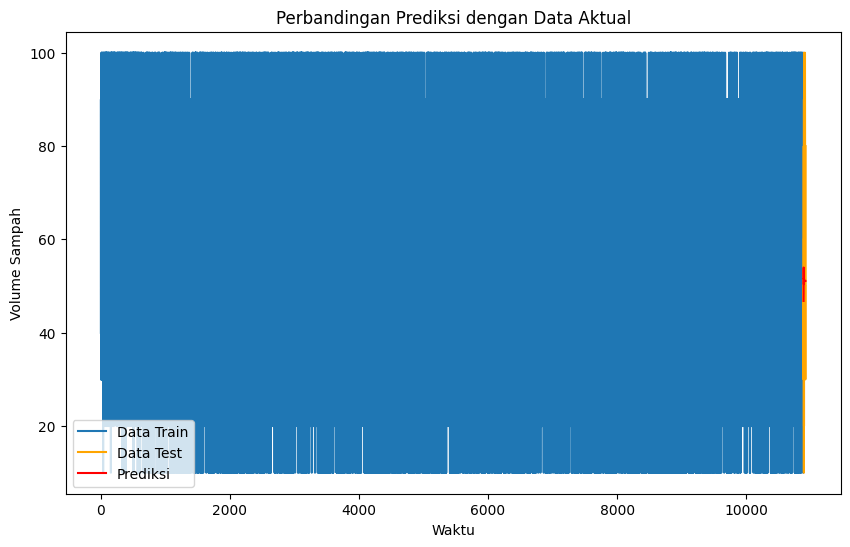

In [ ]:
#Prediksi data uji
n_test = 30
y_train = df['Volume'][:-n_test]
y_test = df['Volume'][-n_test:]

#model ARIMA(5,1,0)
model = ARIMA(y_train, order=(5, 1, 0))
model_fit = model.fit()

y_pred = model_fit.forecast(steps=n_test)

# Evaluasi model
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")

plt.figure(figsize=(10, 6))
plt.plot(y_train.index, y_train, label='Data Train')
plt.plot(y_test.index, y_test, label='Data Test', color='orange')
plt.plot(y_test.index, y_pred, label='Prediksi', color='red')
plt.title('Perbandingan Prediksi dengan Data Aktual')
plt.xlabel('Waktu')
plt.ylabel('Volume Sampah')
plt.legend()
plt.show()

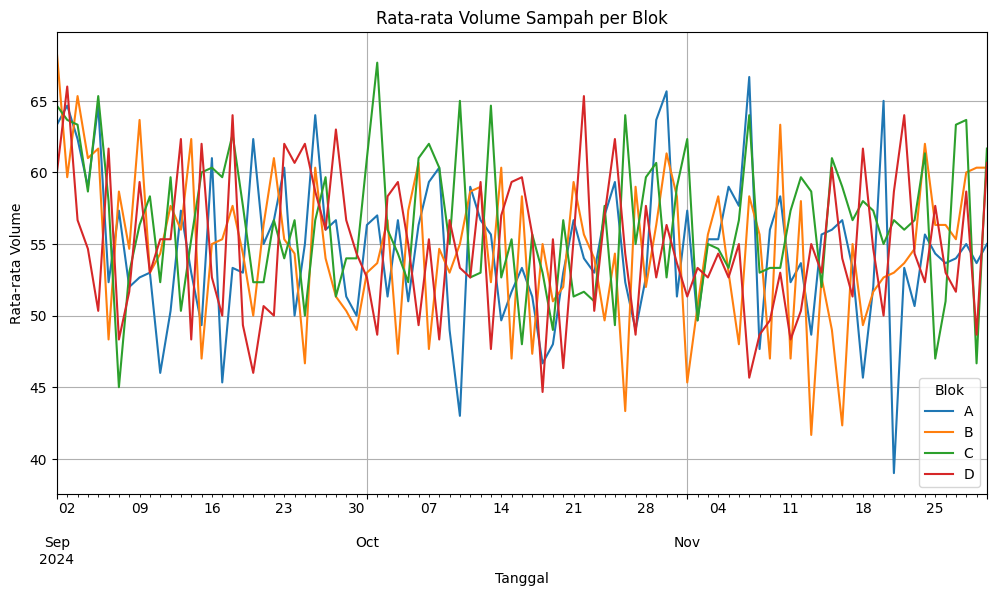

In [ ]:
# Visualisasi rata-rata volume per blok
df_avg = df.groupby(['Tanggal', 'Blok'])['Volume'].mean().reset_index()
pivot_table = df_avg.pivot(index='Tanggal', columns='Blok', values='Volume')

pivot_table.plot(figsize=(12, 6))
plt.title('Rata-rata Volume Sampah per Blok')
plt.ylabel('Rata-rata Volume')
plt.xlabel('Tanggal')
plt.legend(title='Blok')
plt.grid()
plt.show()

In [ ]:
for blok, series in {'A': df_a, 'B': df_b, 'C': df_c, 'D': df_d}.items():
    model = ARIMA(series, order=(1, 1, 1))
    model_fit = model.fit()
    print(f"Prediksi untuk Blok {blok}:")
    print(model_fit.forecast(steps=7))

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/p

Prediksi untuk Blok A:
90    54.311225
91    54.252869
92    54.247924
93    54.247505
94    54.247470
95    54.247467
96    54.247467
Name: predicted_mean, dtype: float64
Prediksi untuk Blok B:
2024-12-01    56.992681
2024-12-02    57.805231
2024-12-03    57.585687
2024-12-04    57.645006
2024-12-05    57.628978
2024-12-06    57.633309
2024-12-07    57.632139
Freq: D, Name: predicted_mean, dtype: float64
Prediksi untuk Blok C:
90    56.524666
91    56.426841
92    56.425094
93    56.425062
94    56.425062
95    56.425062
96    56.425062
Name: predicted_mean, dtype: float64
Prediksi untuk Blok D:
2024-12-01    54.461964
2024-12-02    54.611377
2024-12-03    54.607962
2024-12-04    54.608040
2024-12-05    54.608038
2024-12-06    54.608039
2024-12-07    54.608039
Freq: D, Name: predicted_mean, dtype: float64


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No f

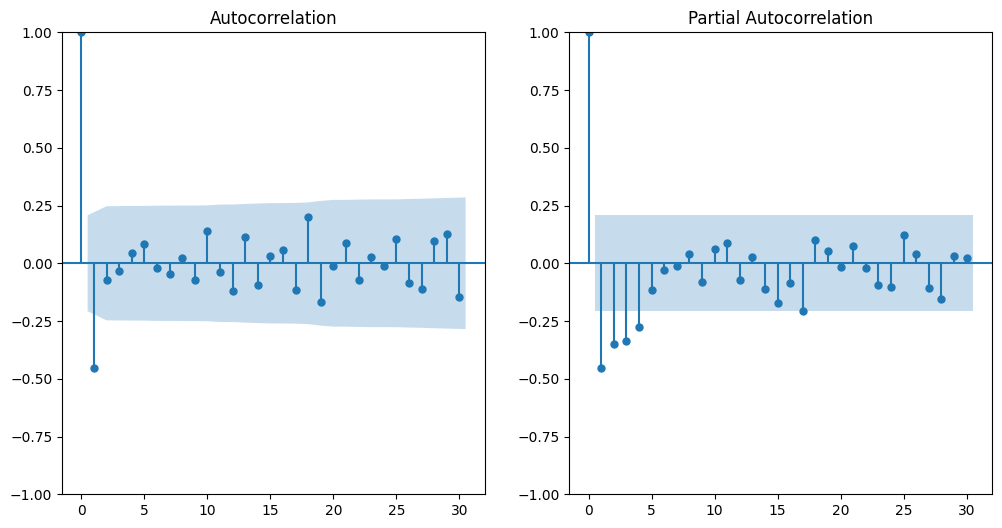

In [ ]:
#menentukan parameter p dan q
plt.figure(figsize=(12, 6))

# Plot ACF
plt.subplot(121)
plot_acf(df_a_diff, lags=30, ax=plt.gca())

# Plot PACF
plt.subplot(122)
plot_pacf(df_a_diff, lags=30, ax=plt.gca())

plt.show()

In [ ]:
#menggunakan parameter p=1, d=1, q=1 setelah analisis
model_a_final = ARIMA(df_a, order=(1, 1, 1))
model_a_fit = model_a_final.fit()

#peramalan
forecast_a = model_a_fit.forecast(steps=7)
print("Prediksi Volume Sampah Blok A untuk 7 hari ke depan:")
print(forecast_a)

Prediksi Volume Sampah Blok A untuk 7 hari ke depan:
90    54.311225
91    54.252869
92    54.247924
93    54.247505
94    54.247470
95    54.247467
96    54.247467
Name: predicted_mean, dtype: float64


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/p

In [ ]:
#klasifikasi kendaraan
def klasifikasi_kendaraan(volume_prediksi, kapasitas_truck):
    persen_volume = (volume_prediksi / kapasitas_truck) * 100
    if persen_volume <= 40:
        return "Viar"
    elif persen_volume <= 60:
        return "Pick-up"
    else:
        return "Truck"
kapasitas_truck = 100

def klasifikasi_kendaraan(volume_prediksi, kapasitas_truck):
    persen_volume = (volume_prediksi / kapasitas_truck) * 100
    if persen_volume <= 40:
        return "Viar"
    elif persen_volume <= 60:
        return "Pick-up"
    else:
        return "Truck"

df_agregat['Rekomendasi_Kendaraan'] = df_agregat['Volume'].apply(lambda v: klasifikasi_kendaraan(v, kapasitas_truck))

print(df_agregat.head())

           Blok  Volume Rekomendasi_Kendaraan
Tanggal                                      
2024-09-01    A      63                 Truck
2024-09-01    C      65                 Truck
2024-09-01    D      60               Pick-up
2024-09-02    A      65                 Truck
2024-09-02    B      60               Pick-up


In [ ]:
pip install firebase-admin

In [ ]:
import firebase_admin
from firebase_admin import credentials
from firebase_admin import credentials, db

if not firebase_admin._apps:
    cred = credentials.Certificate("/content/bismillahptc-2bf27-firebase-adminsdk-1l4m7-bf00aee431.json")
    firebase_admin.initialize_app(cred, {
        'databaseURL': 'https://bismillahptc-2bf27-default-rtdb.firebaseio.com/'
    })


In [ ]:
#menyimpan data ke Realtime Database
def save_to_realtime_db(df_agregat):
    ref = db.reference('prediksi_volumes')

    for index, row in df_agregat.iterrows():
        tanggal = row['Tanggal'].strftime('%Y-%m-%d')
        blok = row['Blok']
        volume = row['Volume']
        kendaraan = row['Rekomendasi_Kendaraan']

        data = {
            'volume': volume,
            'kendaraan': kendaraan
        }

        ref.child(tanggal).child(blok).set(data)
        print(f"Data untuk {tanggal} blok {blok} berhasil disimpan.")

In [ ]:
save_to_realtime_db(df_agregat)

Data untuk 2024-09-01 blok A berhasil disimpan.
Data untuk 2024-09-01 blok C berhasil disimpan.
Data untuk 2024-09-01 blok D berhasil disimpan.
Data untuk 2024-09-02 blok A berhasil disimpan.
Data untuk 2024-09-02 blok B berhasil disimpan.
Data untuk 2024-09-02 blok C berhasil disimpan.
Data untuk 2024-09-02 blok D berhasil disimpan.
Data untuk 2024-09-03 blok A berhasil disimpan.
Data untuk 2024-09-03 blok B berhasil disimpan.
Data untuk 2024-09-03 blok C berhasil disimpan.
Data untuk 2024-09-03 blok D berhasil disimpan.
Data untuk 2024-09-04 blok A berhasil disimpan.
Data untuk 2024-09-04 blok B berhasil disimpan.
Data untuk 2024-09-04 blok C berhasil disimpan.
Data untuk 2024-09-04 blok D berhasil disimpan.
Data untuk 2024-09-05 blok A berhasil disimpan.
Data untuk 2024-09-05 blok B berhasil disimpan.
Data untuk 2024-09-05 blok C berhasil disimpan.
Data untuk 2024-09-05 blok D berhasil disimpan.
Data untuk 2024-09-06 blok A berhasil disimpan.
Data untuk 2024-09-06 blok B berhasil di

In [ ]:
print(df_agregat.columns)

Index(['Blok', 'Volume', 'Rekomendasi_Kendaraan'], dtype='object')


In [ ]:
df_agregat = df_agregat.reset_index()  # Mengembalikan indeks menjadi kolom


In [ ]:
print(df_agregat.head())


     Tanggal Blok  Volume Rekomendasi_Kendaraan
0 2024-09-01    A      63                 Truck
1 2024-09-01    C      65                 Truck
2 2024-09-01    D      60               Pick-up
3 2024-09-02    A      65                 Truck
4 2024-09-02    B      60               Pick-up


In [ ]:
save_to_realtime_db(df_agregat)

NameError: name 'db' is not defined

In [ ]:
#EVALUASI MODEL UNTUK PERBANDINGAN ALGORITMA
import pandas as pd
from sklearn.model_selection import train_test_split
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.ensemble import RandomForestRegressor

In [ ]:
#data
file_path = '/content/Volume Sampah Fix.xlsx'
df = pd.read_excel(file_path)
df['Tanggal'] = pd.to_datetime(df['Tanggal'])
df.set_index('Tanggal', inplace=True)

train_size = int(len(df) * 0.8)
train, test = df[:train_size], df[train_size:]

In [ ]:
# Model ARIMA
model_arima = ARIMA(train['Volume'], order=(1, 1, 1)) #>parameter (p,d,q)
model_arima_fit = model_arima.fit()

pred_arima = model_arima_fit.forecast(steps=len(test))
rmse_arima = mean_squared_error(test['Volume'], pred_arima, squared=False)
mae_arima = mean_absolute_error(test['Volume'], pred_arima)

print(f"ARIMA RMSE: {rmse_arima}, MAE: {mae_arima}")

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


ARIMA RMSE: 28.763031999185653, MAE: 25.067276186228135


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [ ]:
#modwl LSTM
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df['Volume'].values.reshape(-1, 1))

#data window
def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset)-look_back):
        X.append(dataset[i:(i+look_back), 0])
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

look_back = 3
X, y = create_dataset(scaled_data, look_back)

#train dan test
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

#reshape data
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [ ]:
model_lstm = Sequential()
model_lstm.add(LSTM(50, return_sequences=True, input_shape=(look_back, 1)))
model_lstm.add(LSTM(50))
model_lstm.add(Dense(1))
model_lstm.compile(optimizer='adam', loss='mean_squared_error')

model_lstm.fit(X_train, y_train, epochs=20, batch_size=32, verbose=1)

pred_lstm = model_lstm.predict(X_test)
pred_lstm = scaler.inverse_transform(pred_lstm)

rmse_lstm = mean_squared_error(scaler.inverse_transform(y_test.reshape(-1, 1)), pred_lstm, squared=False)
mae_lstm = mean_absolute_error(scaler.inverse_transform(y_test.reshape(-1, 1)), pred_lstm)

print(f"LSTM RMSE: {rmse_lstm}, MAE: {mae_lstm}")

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


273/273 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.1513
Epoch 2/20
273/273 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.1018
Epoch 3/20
273/273 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.1012
Epoch 4/20
273/273 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1005
Epoch 5/20
273/273 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.1021
Epoch 6/20
273/273 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1009
Epoch 7/20
273/273 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.1014
Epoch 8/20
273/273 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1023
Epoch 9/20
273/273 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.1018
Epoch 10/20
273/273 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.1028
Epoch 11/20
273/273 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.1015
Epoch 12/20
273/273 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.1021
Epoch 13/20
273/273 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1000
Epoch 14/20
273/273 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1010
Epoch 15/20
273/273 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.1007


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [ ]:
#Model SARIMAX
model_sarimax = SARIMAX(train['Volume'], order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
model_sarimax_fit = model_sarimax.fit()

pred_sarimax = model_sarimax_fit.forecast(steps=len(test))
rmse_sarimax = mean_squared_error(test['Volume'], pred_sarimax, squared=False)
mae_sarimax = mean_absolute_error(test['Volume'], pred_sarimax)

print(f"SARIMAX RMSE: {rmse_sarimax}, MAE: {mae_sarimax}")

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


SARIMAX RMSE: 28.845380936521977, MAE: 25.0747900076364


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [ ]:
df['day'] = df.index.day
df['month'] = df.index.month

X_rf = df[['day', 'month']]
y_rf = df['Volume']
X_train_rf, X_test_rf, y_train_rf, y_test_rf = train_test_split(X_rf, y_rf, test_size=0.2, random_state=42)

#Model Random Forest
model_rf = RandomForestRegressor(n_estimators=100, random_state=42)
model_rf.fit(X_train_rf, y_train_rf)

pred_rf = model_rf.predict(X_test_rf)
rmse_rf = mean_squared_error(y_test_rf, pred_rf, squared=False)
mae_rf = mean_absolute_error(y_test_rf, pred_rf)

print(f"Random Forest RMSE: {rmse_rf}, MAE: {mae_rf}")

Random Forest RMSE: 29.213785860562155, MAE: 25.465636101921124


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [ ]:
results = {
    'Model': ['ARIMA', 'LSTM', 'SARIMAX', 'Random Forest'],
    'RMSE': [rmse_arima, rmse_lstm, rmse_sarimax, rmse_rf],
    'MAE': [mae_arima, mae_lstm, mae_sarimax, mae_rf]
}

results_df = pd.DataFrame(results)
print(results_df)


           Model       RMSE        MAE
0          ARIMA  28.763032  25.067276
1           LSTM  28.774591  25.070125
2        SARIMAX  28.845381  25.074790
3  Random Forest  29.213786  25.465636
